In [3]:
pip install pyfftw

     |████████████████████████████████| 2.6MB 2.8MB/s 


In [4]:
import numpy as np
import pyfftw
import h5py
from scipy import signal
import matplotlib.pyplot as plt

In [5]:
H1 = h5py.File('H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')
L1 = h5py.File('L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')

In [6]:
strainH1 = H1[u'strain']
strainL1 = L1[u'strain']

dataH1 = np.array(strainH1['Strain'])
dataL1 = np.array(strainL1['Strain'])

In [7]:
print('strain_H1: len, min, mean, max = ', len(dataH1), dataH1.min(),dataH1.mean(),dataH1.max())
print('strain_L1: len, min, mean, max = ', len(dataL1), dataL1.min(),dataL1.mean(),dataL1.max())

strain_H1: len, min, mean, max =  131072 -7.04466594316914e-19 -3.7594485871462737e-23 7.706262192395323e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664246853e-18 -1.0522364772927026e-18 -4.600351113064713e-20


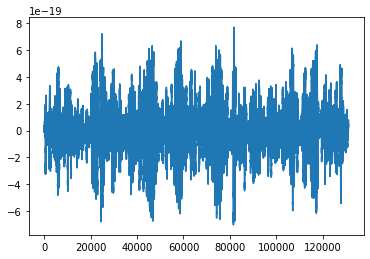

In [8]:
plt.plot(dataH1)
plt.show()

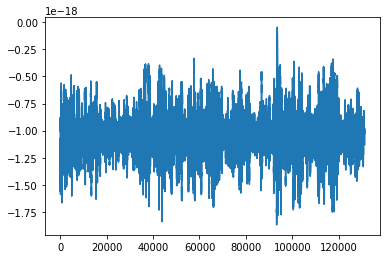

In [9]:
plt.plot(dataL1)
plt.show()

# Metodo de Blackman-Tukey

Para estimar el espectro del ruido se decidio tomar muestras de la senal de forma tal que no se inlcluya el periodo de tiempo en el que aparece la señal correspondiente a la onda gravitacional.
El evento empieza en el segundo 16,422 del archivo utilizado.Dado que la frecuencia de muestreo del archivo es de 4096Hz, el tiempo del evento corresponderia a la muestra numero:
 $$N_{ev} = 16.422seg . 4096Hz= 67264  $$

Por lo que para no incluir al evento se eligen tomar muestras por debajo de 67264, para tener un margen de seguridad se eligio utilizar la potencia de 2 mas cercana por debajo de dicho limite:
$$N=65536$$
N es el valor de muestras utilizadas de la senal para estimar la autocorrelacion de la señal.
Mientras que para el valor de la cantidad de valores que se desea calcular de la autocorrrelacion (denominado L). Se decidio tomar:
$$L= N$$
Este valor se eligio ya que el tiempo de calculo no es ningun limitante en este caso y se desea la mayor resolucion epectral posible. 


In [54]:
N = 65536
L = N
M = 32


Estimo la correlacion de la señal

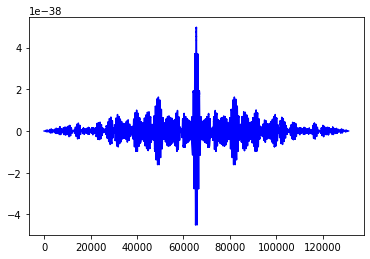

In [11]:
rx = np.correlate(dataH1[0:N],dataH1[0:N],mode='full') / N
rx_truncated = rx[(N-L):(N+L-1)]
plt.plot(rx_truncated,'b')
plt.show()

Aplico la ventana

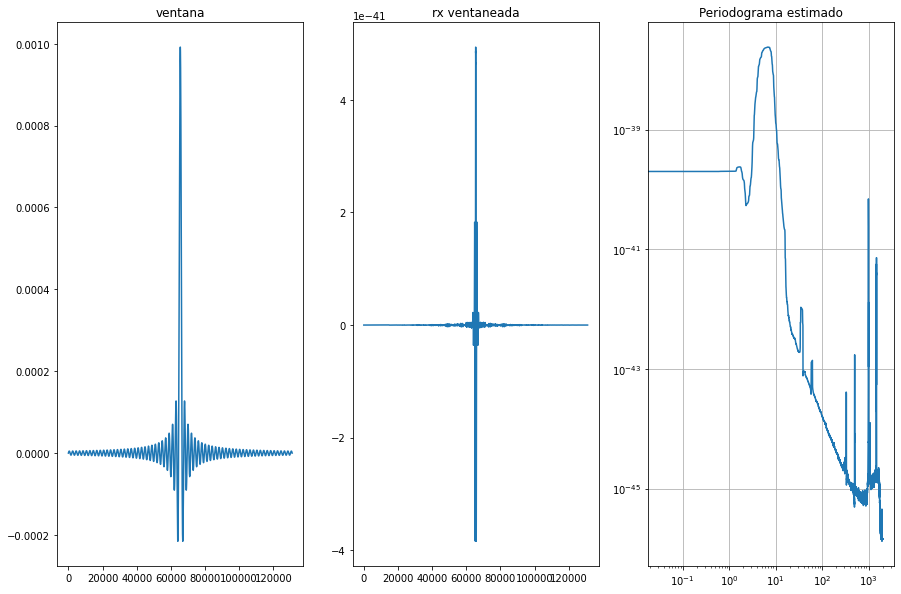

In [55]:
x = ( (2*M+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
window = ( (2*M+1)/L )*np.sinc(x)
windowed_rx = rx_truncated*window
Rx_ps = np.fft.fft(windowed_rx)
f = np.fft.fftfreq(n=len(windowed_rx),d=1./4096)
spectrum = abs(Rx_ps)
fig = plt.figure(figsize=(15,10))
plt.subplot(131)
plt.plot(window)
plt.title("ventana")
plt.subplot(132)
plt.plot(windowed_rx)
plt.title("rx ventaneada")
plt.subplot(133)
plt.title("Periodograma estimado")
plt.plot(f[0:L],spectrum[0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

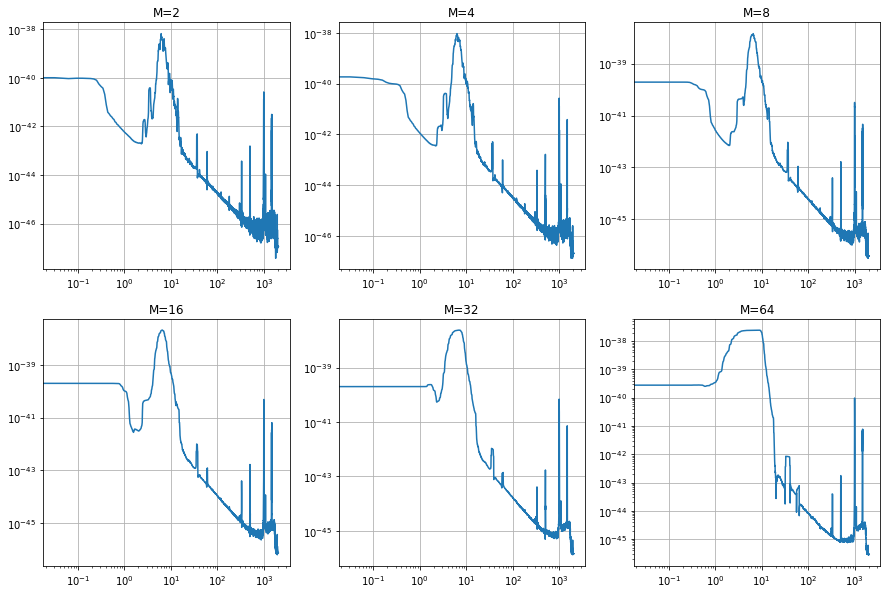

In [35]:
M_values = [2,4,8,16,32,64]
spectrums = []
for M_test in M_values:
  x = ( (2*M_test+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
  window = ( (2*M_test+1)/L )*np.sinc(x)
  windowed_rx = rx_truncated*window
  Rx_ps = np.fft.fft(windowed_rx)
  f = np.fft.fftfreq(n=len(windowed_rx),d=1./4096)
  spectrums.append(abs(Rx_ps))
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
plt.title("M=2")
plt.plot(f[0:L],spectrums[0][0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(232)
plt.title("M=4")
plt.plot(f[0:L],spectrums[1][0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(233)
plt.title("M=8")
plt.plot(f[0:L],spectrums[2][0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(234)
plt.title("M=16")
plt.plot(f[0:L],spectrums[3][0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(235)
plt.title("M=32")
plt.plot(f[0:L],spectrums[4][0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(236)
plt.title("M=64")
plt.plot(f[0:L],spectrums[5][0:L])
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.show()

Como ultima variable a definir, se decidio utilizar para el filtro moving average:
$$M=32$$
Se puede apreciar en las graficas anteriores que dicho valor parece estar justo en el limite entre un mejor suavizado y una perdida de detalle debido a falta de resolucion en frecuencia.